In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter

plt.style.use('ggplot')
stop = set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
import os
open(r"glove.6B.100d.txt")

<_io.TextIOWrapper name='D://Nhan project 2019-2020//NLP//Project//glove.6B.100d.txt' mode='r' encoding='cp1252'>

**Loading dataset**


You can download these files from https://www.kaggle.com/c/nlp-getting-started/data

In [3]:
train = pd.read_csv(r"train.csv")
test = pd.read_csv(r"test.csv")

In [4]:
#%% Viewing dataset
train.head()
#test.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(train.columns)
print(test.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Index(['id', 'keyword', 'location', 'text'], dtype='object')


Text(0, 0.5, 'samples')

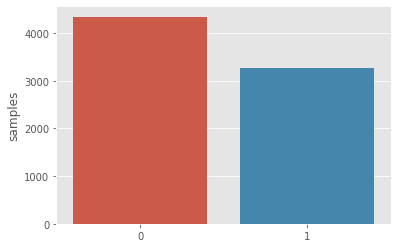

In [6]:
x = train.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

###### Notes : There is a class distribution.There are more trains with class 0 ( No disaster) than class 1 ( disaster trains)


**Numbers of characters in train.csv**

**1.1. The most important feature : "text"**

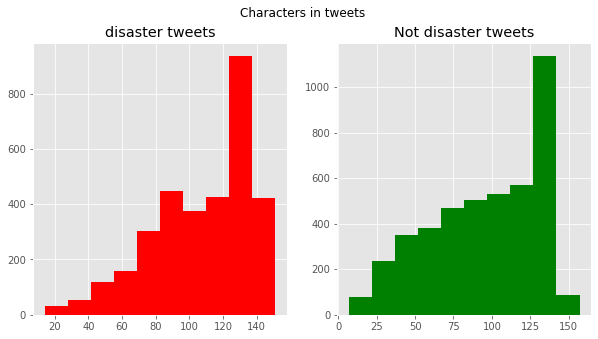

In [7]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (10,5))
train_len = train[train['target'] == 1]['text'].str.len()
ax1.hist(train_len,color = 'red')
ax1.set_title('disaster tweets')
train_len = train[train['target'] == 0]['text'].str.len()
ax2.hist(train_len,color = 'green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

_Number of word in each class_

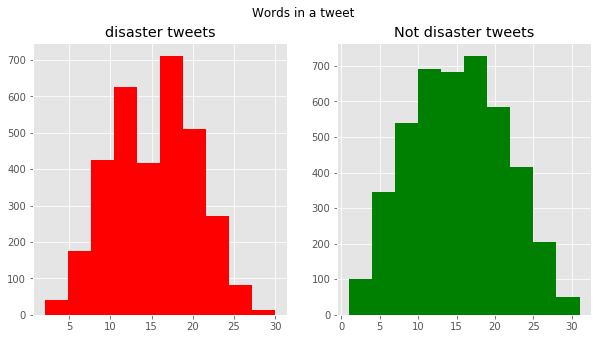

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
train_len = train[train['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color = 'red')
ax1.set_title('disaster tweets')
train_len = train[train['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color = 'green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

_Average words length in tweet_

Text(0.5, 0.98, 'Average word length in each tweet')

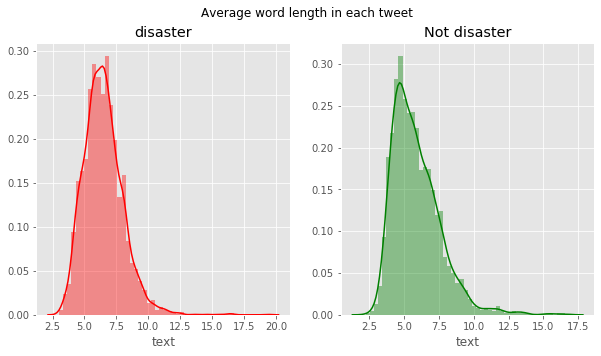

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
word = train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax = ax1, color = 'red')
ax1.set_title('disaster')
word = train[train['target'] == 0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

**1.2. How about the "key-word" colums?** 

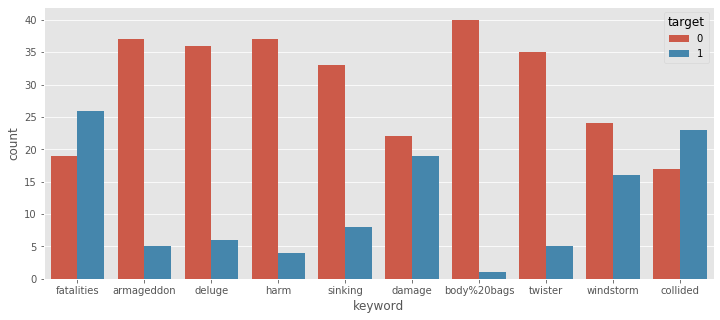

In [10]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.countplot(x = "keyword", 
              hue = "target", 
              data = train,
             order = train.keyword.value_counts().iloc[:10].index,
             ax = ax)

**1.3 And the "location" ?**

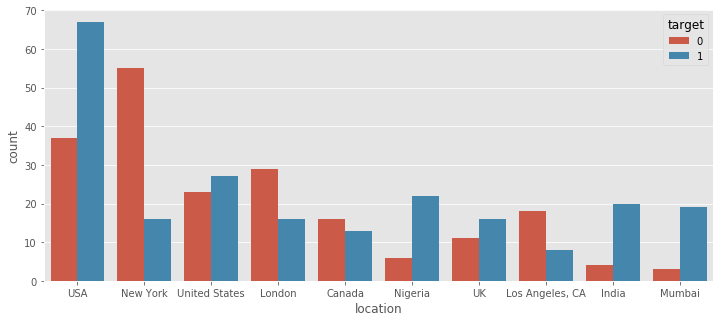

In [11]:
fig, ax = plt.subplots(figsize = (12, 5))
sns.countplot(x = "location", 
              hue = "target", 
              data = train,
             order = train.location.value_counts().iloc[:10].index,
             ax = ax)

In [12]:
loc = train.location.value_counts().iloc[:10].index

In [13]:
train.location.value_counts()[:10]

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: location, dtype: int64

In [14]:
mask = train['location'].isna() == False
print(train[mask][train['location'] == 'Vancouver, Canada']['text'])

7579    Three days off from work and they've pretty mu...
Name: text, dtype: object


C:\Users\Administrator\AppData\Local\conda\conda\envs\evNhan\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


**2. Return the main feature : text**

In [15]:
def create_corpus(target):
    corpus = []    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

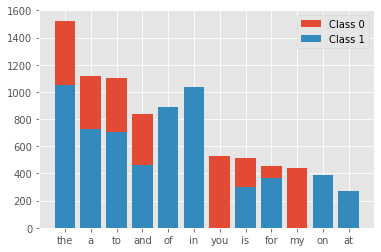

In [16]:
# %% Common stopwords in tweets. First we will analyze tweets with 

# For class 0.
corpus = create_corpus(0)
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1        
top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[ : 10]
#fig, ax = plt.subplots()
x,y = zip(*top)
plt.bar(x, y, label = 'Class 0')
plt.legend()
## For class 1
corpus = create_corpus(1)
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
top = sorted(dic.items(), key = lambda x: x[1], reverse = True)[: 10]     

x, y = zip(*top)
plt.bar(x, y, label = 'Class 1')
plt.legend()
plt.show()

<BarContainer object of 20 artists>

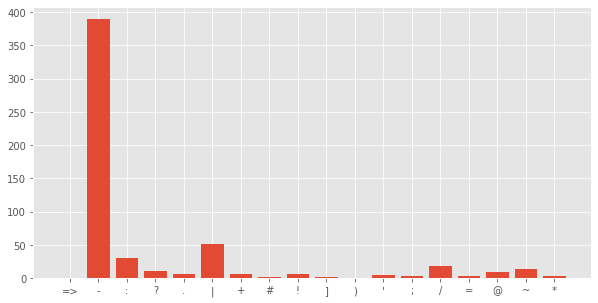

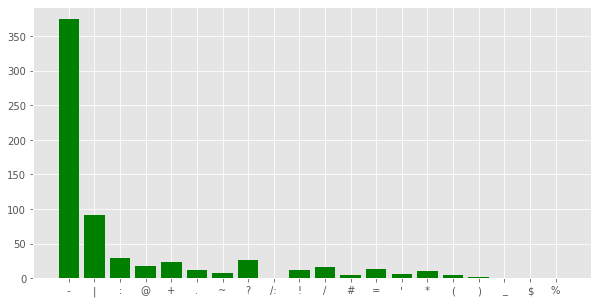

In [17]:
## Real disaster; class 1
plt.figure(figsize = (10,5))
corpus = create_corpus(1)
dic = defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+= 1        
x,y = zip(*dic.items())
plt.bar(x, y)

## For class 0.
plt.figure(figsize = (10,5))
corpus = create_corpus(0)
dic = defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+= 1
        
x, y = zip(*dic.items())
plt.bar(x ,y, color = 'green')

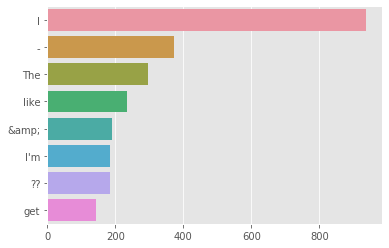

In [18]:
counter = Counter(corpus)
most = counter.most_common()
x = []
y = []
for word,count in most[: 40] :
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x = y, y = x)

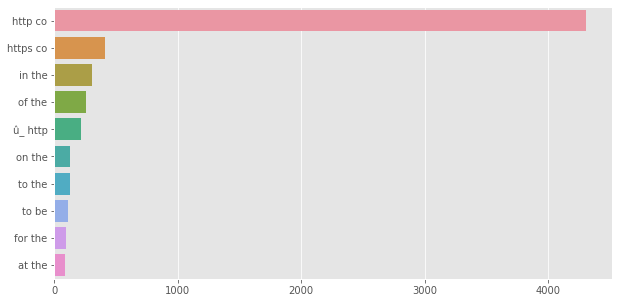

In [19]:
# %% Ngram analysis
# We will do a bigram (n = 2) analysis over the tweets.Let's check the most common bigrams in tweets.
def get_top_tweet_bigrams(corpus, n = None):
    vec = CountVectorizer(ngram_range = (2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[: n]
plt.figure(figsize = (10,5))

top_tweet_bigrams = get_top_tweet_bigrams(train['text'])[:10]

x, y = map(list,zip(*top_tweet_bigrams))

sns.barplot(x = y, y = x)

In [20]:
## Rename :v
df = train
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [21]:
import re
## Removing url
example = "New competition launched :https://www.kaggle.com/c/nlp-getting-started"
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
remove_URL(example)
#df['text'] = df['text'].apply(lambda x : remove_URL(x))

'New competition launched :'

In [22]:
## Removing HTML tags
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))
#df['text'] = df['text'].apply(lambda x : remove_html(x))


Real or Fake
Kaggle 
getting started



In [23]:
# %% Romoving Emojis
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("😔😔No one like me!! So sad!!!😔😔")

'No one like me!! So sad!!!'

In [24]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [25]:
# Removing punctuations
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

example = "@I am a% #king"
print(remove_punct(example))
## Apply to text_column
df['text'] = df['text'].apply(lambda x : remove_punct(x))

I am a king


In [26]:
# Spelling Correction
from spellchecker import SpellChecker
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)        
text = "corect me plese"
correct_spellings(text)

'correct me please'

In [ ]:
## Extract a sub_dataframe with 1000 rows and apply the correct_spelling function
df = df.head(1200)
df['text'] = df['text'].apply(lambda x : correct_spellings(x))

In [28]:
def create_corpus(data):
    corpus=[]
    for tweet in tqdm(data['text']):
        words = [word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [29]:
corpus=create_corpus(df)

100%|████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:00<00:00, 2860.52it/s]


In [30]:
MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)
tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post', padding='post')

In [31]:
len(corpus)

1200

In [32]:
word_index = tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 4229


In [33]:
embedding_dict = {}
with open(r"glove.6B.100d.txt", 'r', encoding='utf8', errors = 'ignore') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word]=vectors
f.close()

In [34]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████████████████████████████████████████████████████████████████████| 4229/4229 [00:00<00:00, 282191.51it/s]


In [35]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           423000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 465,305
Trainable params: 42,305
Non-trainable params: 423,000
_________________________________________________________________


In [39]:
X_tr = tweet_pad[:df.shape[0]]
X_t = tweet_pad[df.shape[0]:]

In [41]:
X_train, X_test,y_train,y_test = train_test_split(X_tr, train['target'][:1200].values,test_size=0.15)
print('Shape of train', X_train.shape)
print("Shape of Validation ", X_test.shape)

Shape of train (1020, 50)
Shape of Validation  (180, 50)


In [42]:
history = model.fit(X_train, y_train, batch_size=4, epochs=15, validation_data = (X_test, y_test), verbose=2)

Train on 1020 samples, validate on 180 samples
Epoch 1/15
 - 26s - loss: 0.5641 - acc: 0.7382 - val_loss: 0.5197 - val_acc: 0.7833
Epoch 2/15
 - 18s - loss: 0.5010 - acc: 0.7980 - val_loss: 0.4695 - val_acc: 0.8278
Epoch 3/15
 - 18s - loss: 0.5549 - acc: 0.6863 - val_loss: 0.5184 - val_acc: 0.7167
Epoch 4/15
 - 17s - loss: 0.5589 - acc: 0.6549 - val_loss: 0.5560 - val_acc: 0.6389
Epoch 5/15
 - 16s - loss: 0.5623 - acc: 0.6980 - val_loss: 0.5105 - val_acc: 0.8056
Epoch 6/15
 - 17s - loss: 0.5136 - acc: 0.7912 - val_loss: 0.6260 - val_acc: 0.7222
Epoch 7/15
 - 18s - loss: 0.5642 - acc: 0.7490 - val_loss: 0.5244 - val_acc: 0.7778
Epoch 8/15
 - 17s - loss: 0.5730 - acc: 0.7343 - val_loss: 0.6561 - val_acc: 0.6389
Epoch 9/15
 - 18s - loss: 0.6382 - acc: 0.6686 - val_loss: 0.6580 - val_acc: 0.6389
Epoch 10/15
 - 19s - loss: 0.6366 - acc: 0.6686 - val_loss: 0.6543 - val_acc: 0.6389
Epoch 11/15
 - 18s - loss: 0.6377 - acc: 0.6686 - val_loss: 0.6571 - val_acc: 0.6389
Epoch 12/15
 - 17s - loss: 